In [ ]:
# Install specific, compatible versions
!pip install -q -U transformers peft accelerate bitsandbytes trl datasets

print("✅ Clean and compatible libraries installed successfully.")

Found existing installation: transformers 4.55.2
Uninstalling transformers-4.55.2:
  Successfully uninstalled transformers-4.55.2
Found existing installation: accelerate 1.10.0
Uninstalling accelerate-1.10.0:
  Successfully uninstalled accelerate-1.10.0
Found existing installation: trl 0.21.0
Uninstalling trl-0.21.0:
  Successfully uninstalled trl-0.21.0
Found existing installation: peft 0.17.0
Uninstalling peft-0.17.0:
  Successfully uninstalled peft-0.17.0
Found existing installation: bitsandbytes 0.47.0
Uninstalling bitsandbytes-0.47.0:
  Successfully uninstalled bitsandbytes-0.47.0
✅ Clean and compatible libraries installed successfully.


In [ ]:
from google.colab import userdata
import os

# Use Colab Secrets to store your Hugging Face token
os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')

print("🔑 Hugging Face token configured.")

🔑 Hugging Face token configured.


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from datasets import load_dataset

# --- Model & Tokenizer Loading ---
model_id = "google/gemma-2b-it"
print(f"🔄 Loading model: {model_id}")

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
tokenizer = AutoTokenizer.from_pretrained(model_id, token=os.environ["HF_TOKEN"])
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=quantization_config,
    device_map="auto",
    token=os.environ["HF_TOKEN"]
)
print("✅ Model and Tokenizer loaded.")

# --- Dataset Loading & Formatting ---
dataset_id = "har1/MTS_Dialogue-Clinical_Note"
print(f"🔄 Loading and preparing dataset: {dataset_id}")

def format_prompt(example):
    prompt = f"""<start_of_turn>user
From the following doctor-patient dialogue, extract the key information and write the '{example['section_header']}' section of a clinical note.

### Dialogue:
{example['dialogue']}<end_of_turn>
<start_of_turn>model
### Clinical Note Section:
{example['section_text']}<end_of_turn>"""
    return {"text": prompt}

processed_dataset = load_dataset(dataset_id, split="train").map(format_prompt)
print("✅ Dataset prepared with 'text' column.")

🔄 Loading model: google/gemma-2b-it


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Model and Tokenizer loaded.
🔄 Loading and preparing dataset: har1/MTS_Dialogue-Clinical_Note
✅ Dataset prepared with 'text' column.


In [ ]:
from peft import LoraConfig
from trl import SFTConfig, SFTTrainer

# --- LoRA Config (No changes needed here) ---
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    lora_dropout=0.05,
    task_type="CAUSAL_LM",
)

# --- SFTConfig (This is where we make the changes) ---
training_config = SFTConfig(
    output_dir="scribe-assist-gemma-finetuned",
    num_train_epochs=1,
    per_device_train_batch_size=1,      # <-- CHANGED FROM 2 to 1
    gradient_accumulation_steps=16,   # <-- CHANGED FROM 8 to 16
    learning_rate=2e-4,
    logging_steps=25,
    save_strategy="epoch",
    save_total_limit=2,
    optim="paged_adamw_8bit",
    dataset_text_field="text",
    max_length=1024,
    report_to="none",
)

# --- SFTTrainer (Using your exact working structure) ---
trainer = SFTTrainer(
    model=model,
    processing_class=tokenizer,
    train_dataset=processed_dataset,
    peft_config=lora_config,
    args=training_config,
)

print("✅ Trainer configured with your working structure and memory optimizations.")

✅ Trainer configured with your working structure and memory optimizations.


In [ ]:
import logging

# Set logging to info to see underlying details
logging.basicConfig(level=logging.INFO)

print("🚀 Starting the fine-tuning process...")
print("If the session disconnects, the latest checkpoint will be in the output directory.")

try:
  # This command starts the training.
  # The trainer will automatically save checkpoints at the end of each epoch
  # because we set save_strategy="epoch".
  trainer.train()

  print("✅ Fine-tuning completed successfully!")

finally:
  # This block will execute NO MATTER WHAT happens in the `try` block.
  # This is our safety net to save the final model state.
  print("\n💾 Saving the final model adapter...")
  trainer.save_model("scribe-assist-gemma-final-adapter")
  print("✅ Final model adapter saved successfully to 'scribe-assist-gemma-final-adapter'.")

🚀 Starting the fine-tuning process...
If the session disconnects, the latest checkpoint will be in the output directory.


Step,Training Loss
25,1.876700
50,1.363900
75,1.305500


✅ Fine-tuning completed successfully!

💾 Saving the final model adapter...
✅ Final model adapter saved successfully to 'scribe-assist-gemma-final-adapter'.


In [ ]:
from peft import PeftModel
import torch

# The path to our saved adapter
adapter_path = "scribe-assist-gemma-final-adapter"

print("🔄 Loading the fine-tuned model for inference...")

# Load the base model in 4-bit (as we did before)
base_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=quantization_config,
    device_map="auto",
    token=os.environ["HF_TOKEN"]
)

# Load the PeftModel by merging the adapter into the base model
model = PeftModel.from_pretrained(base_model, adapter_path)

# Merge the layers to make inference faster
model = model.merge_and_unload()

print("✅ Fine-tuned model loaded and merged successfully.")

🔄 Loading the fine-tuned model for inference...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/bnb.py:348: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


✅ Fine-tuned model loaded and merged successfully.


In [ ]:
from datasets import load_dataset

# Load the original dataset to select a clean test case
raw_dataset = load_dataset("har1/MTS_Dialogue-Clinical_Note", split="train")

# Select a challenging example (e.g., index 52)
test_case = raw_dataset[52]
test_dialogue = test_case['dialogue']
test_header = test_case['section_header']
ground_truth_note = test_case['section_text']

# Prepare the prompt for the models
instruction = f"From the following doctor-patient dialogue, extract the key information and write the '{test_header}' section of a clinical note."
prompt = f"""<start_of_turn>user
{instruction}

### Dialogue:
{test_dialogue}<end_of_turn>
<start_of_turn>model
### Clinical Note Section:
"""

# Tokenize the prompt for inference
inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

print("✅ Test case selected and prepared successfully.")

✅ Test case selected and prepared successfully.


In [ ]:
print("--- 🧠 BASE MODEL (BEFORE FINE-TUNING) ---")

# Load the original, un-tuned base model
original_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16, # Use bfloat16 for faster inference
    device_map="auto",
    token=os.environ["HF_TOKEN"]
)

# Generate and decode the output
outputs = original_model.generate(**inputs, max_new_tokens=200)
decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(decoded_output.split("### Clinical Note Section:")[1].strip())


# --- SEPARATOR ---
print("\n" + "="*80 + "\n")


print("--- ✨ SCRIBE-ASSIST (AFTER FINE-TUNING) ---")

# Generate and decode the output from our fine-tuned model
# 'model' is the variable holding our merged, fine-tuned model from the previous step
outputs = model.generate(**inputs, max_new_tokens=200)
decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(decoded_output.split("### Clinical Note Section:")[1].strip())


# --- SEPARATOR ---
print("\n" + "="*80 + "\n")


print("--- 🎯 GROUND TRUTH (THE IDEAL NOTE) ---")
print(ground_truth_note)

--- 🧠 BASE MODEL (BEFORE FINE-TUNING) ---


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

GENHX: Patient is a 85-year-old male with a history of alcohol abuse and falls. He was found unconscious in his home and was admitted to the emergency room the night before.


--- ✨ SCRIBE-ASSIST (AFTER FINE-TUNING) ---
Patient: Mister Smith, 85 years old.
Presenting complaint: Fall from wheelchair resulting in facial injuries.
History of present illness: Patient was admitted to the emergency room the night before with concerns of head injury. He was found in the home unresponsive and barley conscious. Patient was found in the home by his wife.
Physical examination: Facial injuries, including a laceration on the left cheek.
Investigations: Adult Protective Services were contacted and are investigating the incident.


--- 🎯 GROUND TRUTH (THE IDEAL NOTE) ---
Symptoms: Decreased level of consciousness, facial injuries, possible elderly abuse, history of falling from wheelchair.
Diagnosis: N/A (awaiting further evaluation).
History of Patient: Patient experienced decreased mental status fo

In [ ]:
# Define a name for the local directory
local_save_path = "scribe-assist-gemma-adapter"

# Save the adapter weights
trainer.save_model(local_save_path)

print(f"✅ Model adapter successfully saved to the folder: '{local_save_path}'")

✅ Model adapter successfully saved to the folder: 'scribe-assist-gemma-adapter'


✅ Training loss curve generated and saved as 'training_loss_curve.png'


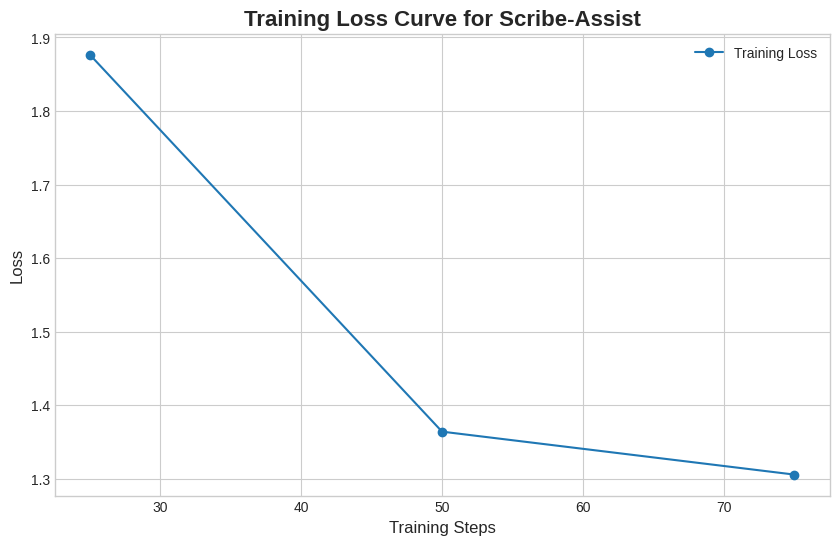

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract the training logs from the trainer's history
training_logs = trainer.state.log_history

# Filter out the logs that contain the training loss
loss_logs = [log for log in training_logs if 'loss' in log]

# Create a pandas DataFrame for easy plotting
df = pd.DataFrame(loss_logs)

# Create the plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df['step'], df['loss'], marker='o', linestyle='-', color='#1f77b4', label='Training Loss')

# Add titles and labels for clarity
ax.set_title('Training Loss Curve for Scribe-Assist', fontsize=16, fontweight='bold')
ax.set_xlabel('Training Steps', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True)

# Save the plot as a high-quality image
plt.savefig('training_loss_curve.png', dpi=300, bbox_inches='tight')

print("✅ Training loss curve generated and saved as 'training_loss_curve.png'")
plt.show()